In [1]:
import os
import operator
import numpy as np
from typing import List
from gensim.models import KeyedVectors, Word2Vec
from gensim.test.utils import datapath
import matplotlib.pyplot as plt

In [2]:
def load_dataset(path) -> List[tuple[List[str], str]]:
    result = []
    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(path + '/' + file) as f:
                cluster_reading = True
                cluster = []
                outliers = []
                for line in f:
                    line = line.rstrip()
                    if len(line) > 0:
                        if not line.startswith('#'):
                            if cluster_reading:
                                cluster.append(line)
                            else:
                                outliers.append(line)
                    else:
                        cluster_reading = False
                for outlier in outliers:
                    result.append((cluster, outlier))
    return result

In [3]:
def compute_accuracy(dataset, sim_fun):
    similarities = {}
    correct_guesses = 0
    total_guesses = 0
    for sample in dataset:
        cluster, outlier = sample
        items = cluster + [outlier]
        compactness = {}
        for item1 in items:
            compactness[item1] = 0.0
            for item2 in items:
                if item1 != item2:
                    compactness[item1] += sim_fun(item1, item2)
        least_compact = sorted(compactness.items(), key=operator.itemgetter(1))[0][0]
        if least_compact == outlier:
            correct_guesses += 1
        else:
            print(f"Failed {cluster} / {outlier}")
        total_guesses += 1
    return correct_guesses / total_guesses

In [4]:
wv = KeyedVectors.load_word2vec_format('word2vec-cc100-skipgram-d100-w3-min10.vectors', binary=False)

In [5]:
wv.similarity('шчанюк', 'сабака')

0.6929014

In [6]:
eval_dataset = load_dataset('evaluation/outlier-detection')

In [7]:
compute_accuracy(eval_dataset, lambda w1, w2: wv.similarity(w1, w2))

Failed ['яблык', 'банан', 'апельсін', 'персік', 'груша', 'сліва', 'мандарын', 'ківі'] / морква
Failed ['яблык', 'банан', 'апельсін', 'персік', 'груша', 'сліва', 'мандарын', 'ківі'] / зеляніна
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / рака
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / кіт
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / плаўнік
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / дно
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / васьміног
Failed ['ласось', 'карп', 'шчупак', 'акунь', 'вугор', 'плотка', 'сом', 'стронга'] / човен
Failed ['планета', 'зорка', 'камета', 'астэроід', 'галактыка', 'метэарыт', 'квазар', 'туманнасць'] / марс
Failed ['таракан', 'клешч', 'муха', 'вош', 'клоп', 'блыха', 'камар', 'авадзень'] / пацук
Failed ['таракан', 'клешч', 'муха', 'вош', 'клоп', 'блыха', 'камар', 'ав

0.8275862068965517

In [8]:
model = Word2Vec.load("word2vec-cc100-skipgram-d100-w3-min10.model")

Let's check whether we have correlation between frequency of a word and its average similarity to another word.

In [9]:
vocab_size = len(model.wv.index_to_key)
pairs = [(np.random.randint(vocab_size), np.random.randint(vocab_size)) for _ in range(1000)]
similarities = [model.wv.similarity(model.wv.index_to_key[p[0]], model.wv.index_to_key[p[1]]) for p in pairs]

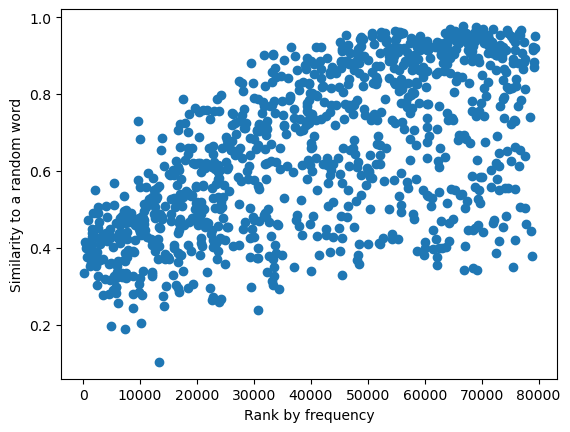

In [10]:
plt.scatter([p[0] for p in pairs], similarities)
plt.xlabel('Rank by frequency')
plt.ylabel('Similarity to a random word')
plt.show()

Checking most similar words for a rare word:

In [11]:
model.wv.get_vecattr("пітон","count")

289

In [12]:
closest_words = []
for word, similarity in model.wv.most_similar('пітон', topn=5000):
    closest_words.append((word, similarity, model.wv.get_vecattr(word,"count"))) 

for word, similarity, count in closest_words[:20]:
    print(word.ljust(10) + "\t" + "%.2f" % similarity, count)

вожыкаў   	0.92 259
вушасты   	0.92 195
бегемот   	0.92 259
лемур     	0.92 130
гепард    	0.92 112
эму       	0.92 117
гіпапатам 	0.92 106
тэр'ер    	0.91 165
хвастаты  	0.91 182
лісяня    	0.91 86
андатра   	0.91 121
каёт      	0.91 77
жывёлка   	0.91 144
ігуана    	0.91 68
палёўка   	0.91 122
сумчаты   	0.91 133
тэрарыум  	0.90 65
гіена     	0.90 237
макака    	0.90 110
мопс      	0.90 62


It seems rare words are very close to other rare words. Let's find whether some frequent words are close too.

In [13]:
frequent_words = [i for i in range(len(closest_words)) if closest_words[i][2] > 800]
frequent_words

[1245, 1612, 4979]

In [14]:
for ind in frequent_words:
    word, similarity, count = closest_words[ind]
    print(word.ljust(10) + "\t" + "%.2f" % similarity, count)

яшчарка   	0.85 803
звярок    	0.85 944
папугай   	0.84 1002


Doesn't make sense even for more frequent words. Let's check the structure of vectors

In [15]:
model.wv.get_vector('пітон')

array([-0.20692627, -0.03510995,  0.04575301,  0.22057971, -0.03002238,
       -0.2510972 , -0.10136665,  0.2681942 ,  0.01277593, -0.07813759,
       -0.2407417 , -0.1409162 , -0.10782281,  0.00314819, -0.02486886,
       -0.11432322, -0.09735473, -0.26175928,  0.20865765, -0.09891994,
        0.28715137, -0.01170491,  0.04473926,  0.03803572,  0.08062349,
        0.05174757, -0.30050737, -0.104582  , -0.263746  , -0.08128537,
        0.02163813,  0.11052897, -0.24461095, -0.28112635, -0.01910536,
        0.15430102, -0.09254131, -0.09917375, -0.16841832, -0.25644922,
        0.06669102, -0.25324893, -0.19188388, -0.0602125 , -0.0120755 ,
       -0.17976435, -0.28852782, -0.01225851, -0.00997326,  0.10002602,
        0.06708702, -0.26055038,  0.10995039, -0.0361857 , -0.22166611,
        0.05220208,  0.03716289, -0.05555607, -0.0685412 , -0.07319065,
        0.02038205,  0.11216445, -0.3043089 ,  0.00975868, -0.2572531 ,
        0.18507336,  0.06441233,  0.06302129, -0.07481578,  0.28

In [16]:
np.mean(np.abs(model.wv.get_vector('пітон')))

0.123844035

In [17]:
np.mean(np.abs(model.wv.get_vector('беларусь')))

0.45805874

In [18]:
coord_abs_values = [np.mean(np.abs(model.wv.get_vector(word))) for word in model.wv.index_to_key]

Text(0, 0.5, 'Mean absolute coordinate value of embedding')

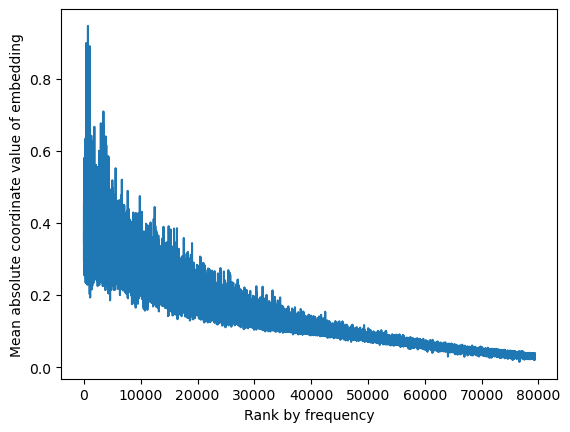

In [19]:
plt.plot(coord_abs_values)
plt.xlabel('Rank by frequency')
plt.ylabel('Mean absolute coordinate value of embedding')

Seems rare words have low absolute values for coordinates. This however doesn't explain the clustering of them from cosine similarity perspective.